In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum_welch
from fooof.plts.spectra import plot_spectrum
from fooof.plts.fm import plot_fm
from glob import glob
from scipy import signal
from fooof import FOOOF
from fooof.core.funcs import gaussian_function
from fooof.sim import gen_freqs
import sys
import os
from pathlib import Path
from natsort import natsorted
# get file path
file_path = Path().absolute()
project_path = file_path.parent.parent

print(file_path)
print(project_path)

os.chdir(project_path)
sys.path.append(project_path)

from src import *

/Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves/exp/2022-11-29_exp
/Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves


In [4]:
# read the data
data = sorted(glob('raw/2022-09-27_data/1kHz/lfp*.ibw'))
# get 1st probe data
files_1st_probe = natsorted([d for d in data if int(d.split('/')[-1].split('.')[0].split('p')[-1]) >= 65 and int(d.split('/')[-1].split('.')[0].split('p')[-1]) <= 80])
# get 2nd probe data
files_2st_probe = natsorted([d for d in data if int(d.split('/')[-1].split('.')[0].split('p')[-1]) >= 97 and int(d.split('/')[-1].split('.')[0].split('p')[-1]) <= 112])

# load the data
data_1st_probe = [load_ibw_data(f)[0] for f in files_1st_probe]
data_2st_probe = [load_ibw_data(f)[0] for f in files_2st_probe]

# get the times
times = load_ibw_data(files_1st_probe[0])[1]

# get the sampling rate
fs = data_1st_probe[0].sampling_rate

# get the time series
ts_1st_probe = [np.squeeze(d.magnitude) for d in data_1st_probe]
ts_2nd_probe = [np.squeeze(d.magnitude) for d in data_2st_probe]

In [5]:
# filter the data for line noise
ts_1st_probe_filtered = [filter_line_noise(ts, fs.magnitude, 550) for ts in ts_1st_probe]
ts_2nd_probe_filtered = [filter_line_noise(ts, fs.magnitude, 550) for ts in ts_2nd_probe]


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                         

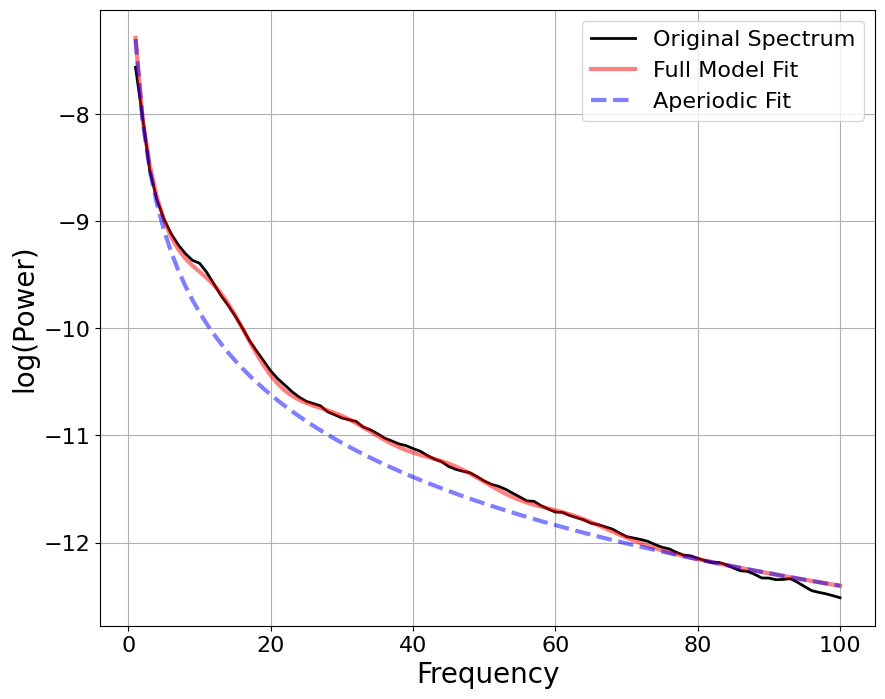

In [8]:
# Initialize a FOOOF object
fm = FOOOF()

# Compute a power spectrum
freqs, powers = compute_spectrum_welch(ts_1st_probe_filtered[0], fs=1000)

# Set the frequency range to fit the model
freq_range = [0, 100] # what freqs range shoul I use? 

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freqs, powers, freq_range)

Next cell shows the equivalence between FOOOF peak frequency plotting and the peak frequency plotting in the matplotlib.

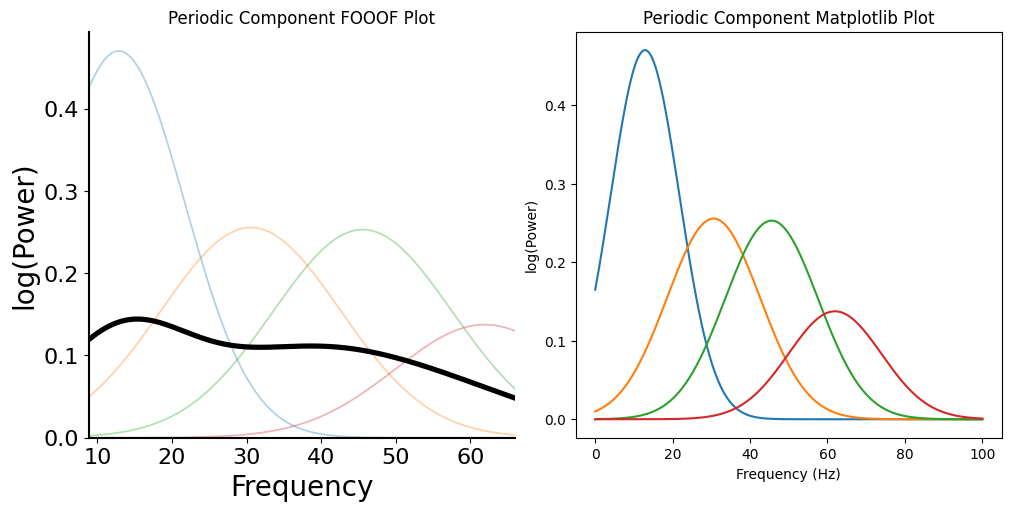

In [19]:
# plotting periodic component
from fooof.analysis import get_band_peak_fm
from fooof.plts.periodic import plot_peak_fits

# create 3 plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

peak_params = get_band_peak_fm(fm, [0, 100], select_highest=False)
plot_peak_fits(peak_params, ax=axes[0])
axes[0].set_title('Periodic Component FOOOF Plot')

for peak_param in peak_params:
    freq_range = [0, 100]
    freqs = gen_freqs(freq_range, 0.1)
    peak_vals = gaussian_function(freqs, *peak_param)
    axes[1].plot(freqs, peak_vals)
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('log(Power)') # what units? 
    axes[1].set_title('Periodic Component Matplotlib Plot')

plt.show()

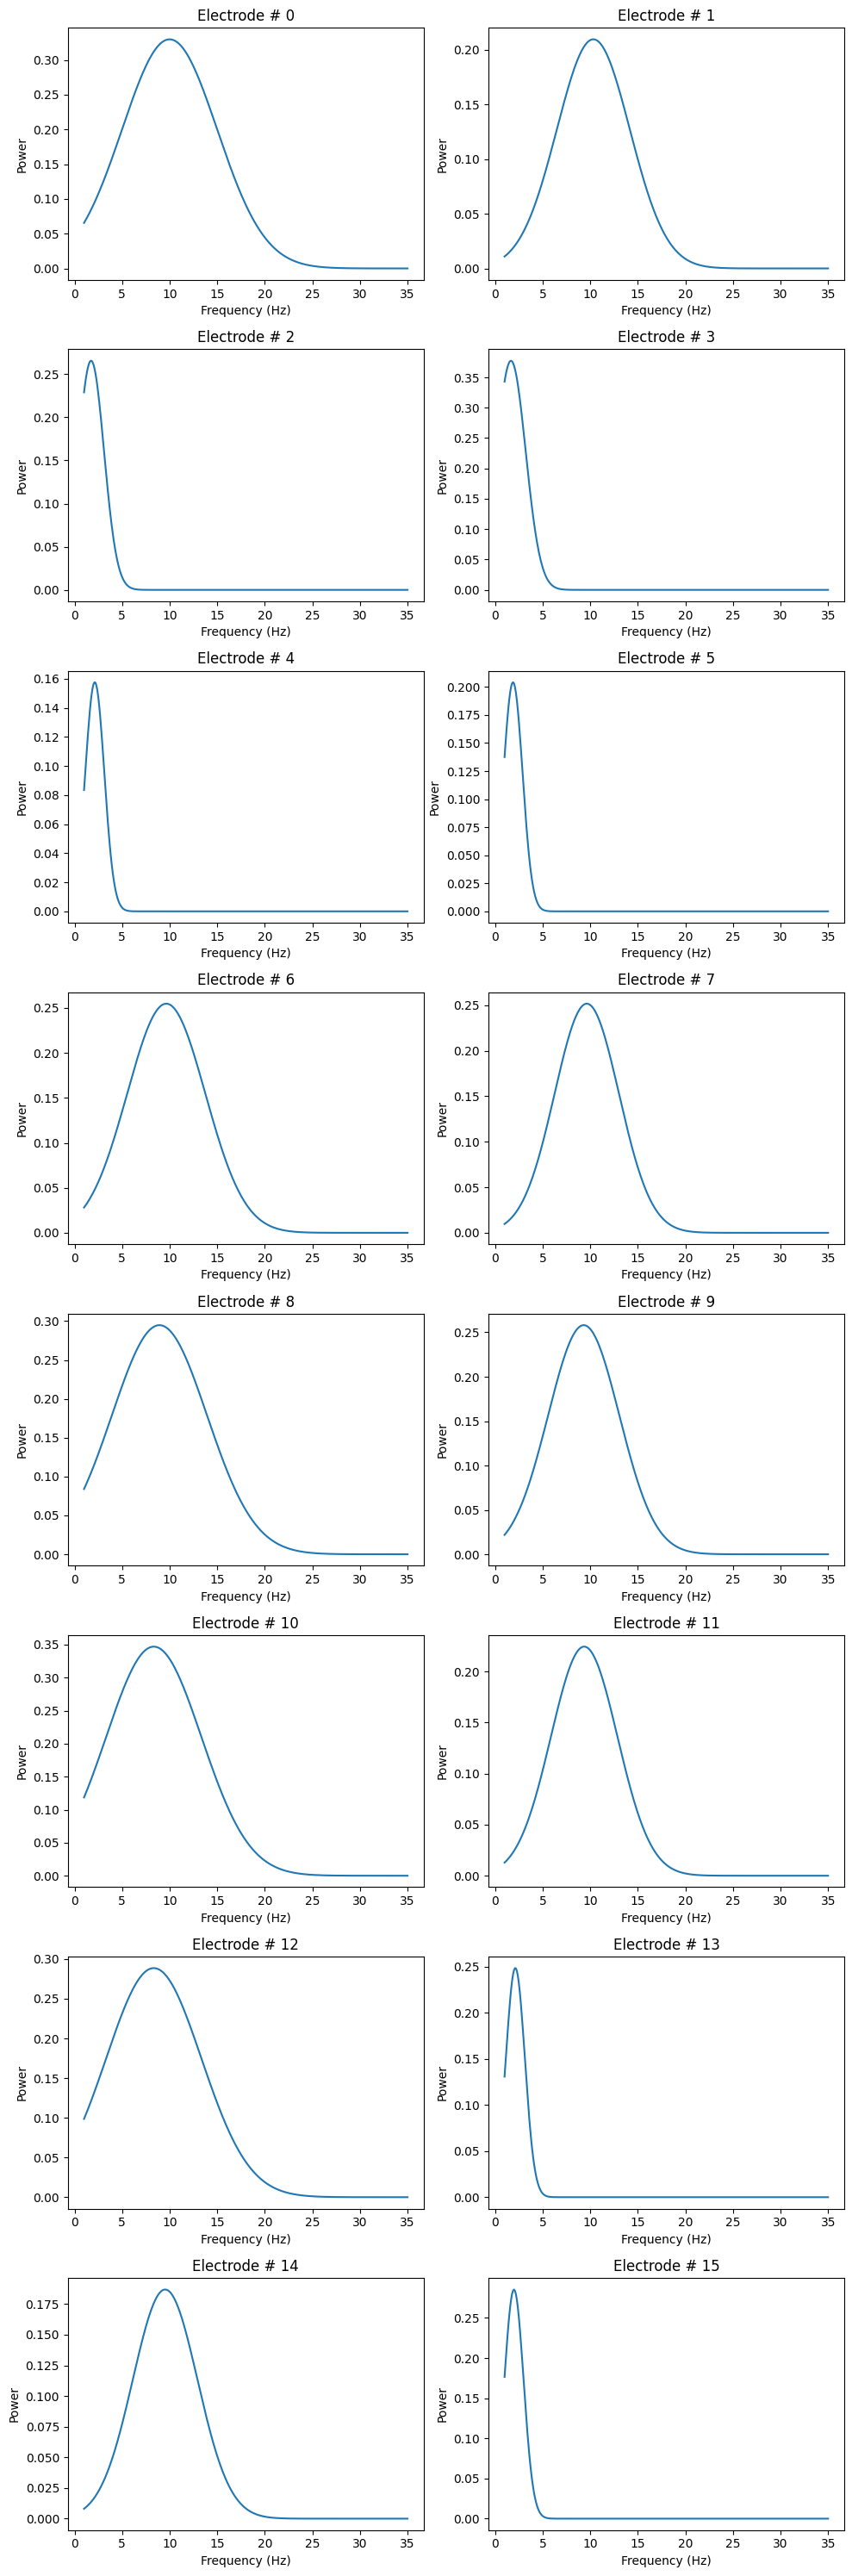

In [13]:
# for each data file, compute the power spectrum density using welch method, fit fooof model and plot the periodic component
freq_range=[1, 35]

# prepare matplotlib axes
fig, axes = plt.subplots(int(len(ts_1st_probe_filtered)/2), 2, figsize=(10, 30))
axes = axes.flatten()
for i, (ts, ax) in enumerate(zip(ts_1st_probe_filtered, axes)):
    # compute the power spectrum density
    freqs, powers = compute_spectrum_welch(ts, fs=1000)
    # fit fooof model
    fm = FOOOF(verbose=False, peak_width_limits=[1, 5])
    fm.fit(freqs, powers, freq_range=freq_range)
    # plot the periodic component
    peak_params = get_band_peak_fm(fm, freq_range, select_highest=True)
    # for peak_param in peak_params:
    freqs = gen_freqs(freq_range, 0.1)
    peak_vals = gaussian_function(freqs, *peak_params)
    ax.plot(freqs, peak_vals)
        
    # improve the figure
    ax.set_title('Electrode # {}'.format(i))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power') # what units? 

plt.tight_layout()
plt.show()

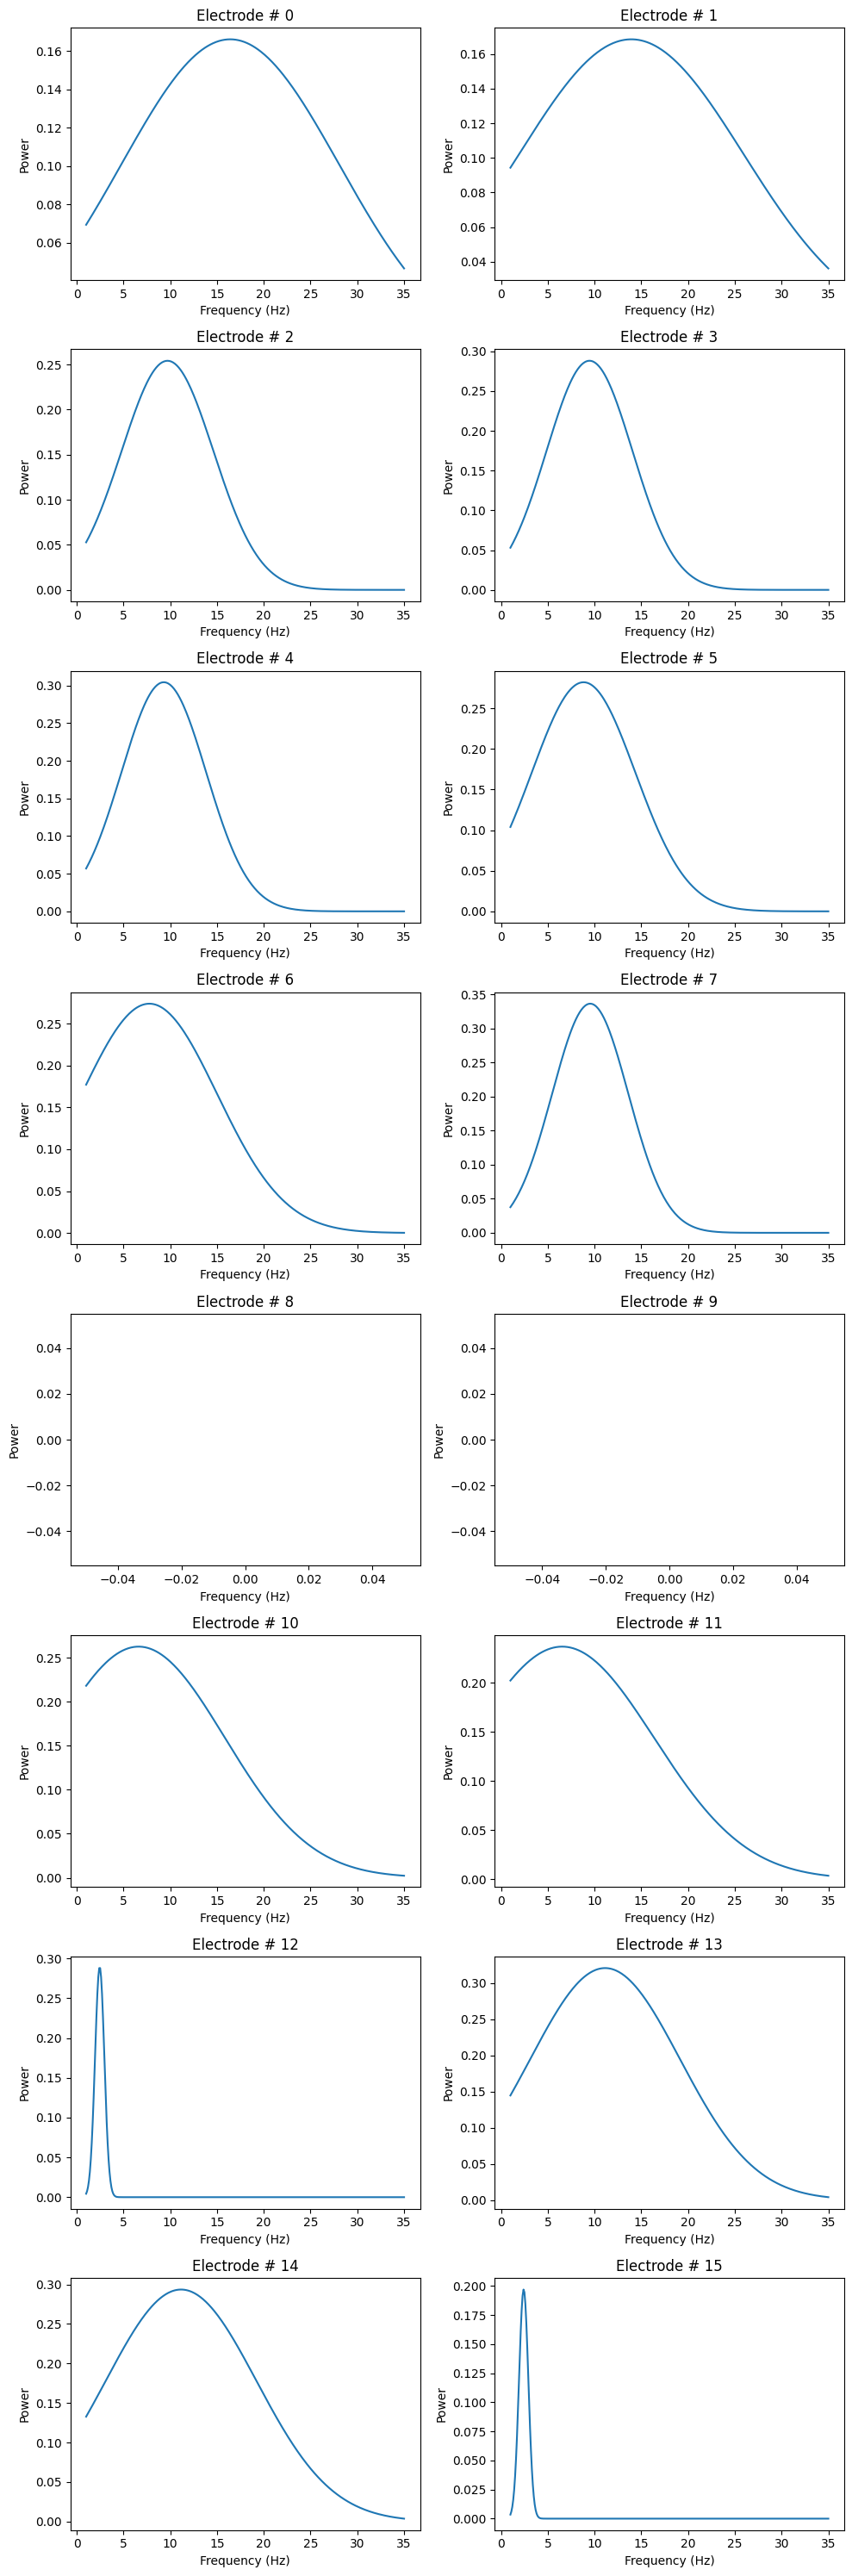

In [15]:
# for each data file, compute the power spectrum density using welch method, fit fooof model and plot the periodic component
freq_range=[1, 35]

# prepare matplotlib axes
fig, axes = plt.subplots(int(len(ts_2nd_probe_filtered)/2), 2, figsize=(10, 30))
axes = axes.flatten()
for i, (ts, ax) in enumerate(zip(ts_2nd_probe_filtered, axes)):
    # compute the power spectrum density
    freqs, powers = compute_spectrum_welch(ts, fs=1000)
    # fit fooof model
    fm = FOOOF(verbose=False)
    fm.fit(freqs, powers, freq_range=freq_range)
    # plot the periodic component
    peak_params = get_band_peak_fm(fm, freq_range, select_highest=True)
    # for peak_param in peak_params:
    freqs = gen_freqs(freq_range, 0.1)
    peak_vals = gaussian_function(freqs, *peak_params)
    ax.plot(freqs, peak_vals)
        
    # improve the figure
    ax.set_title('Electrode # {}'.format(i))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power') # what units? 

plt.tight_layout()
plt.show()

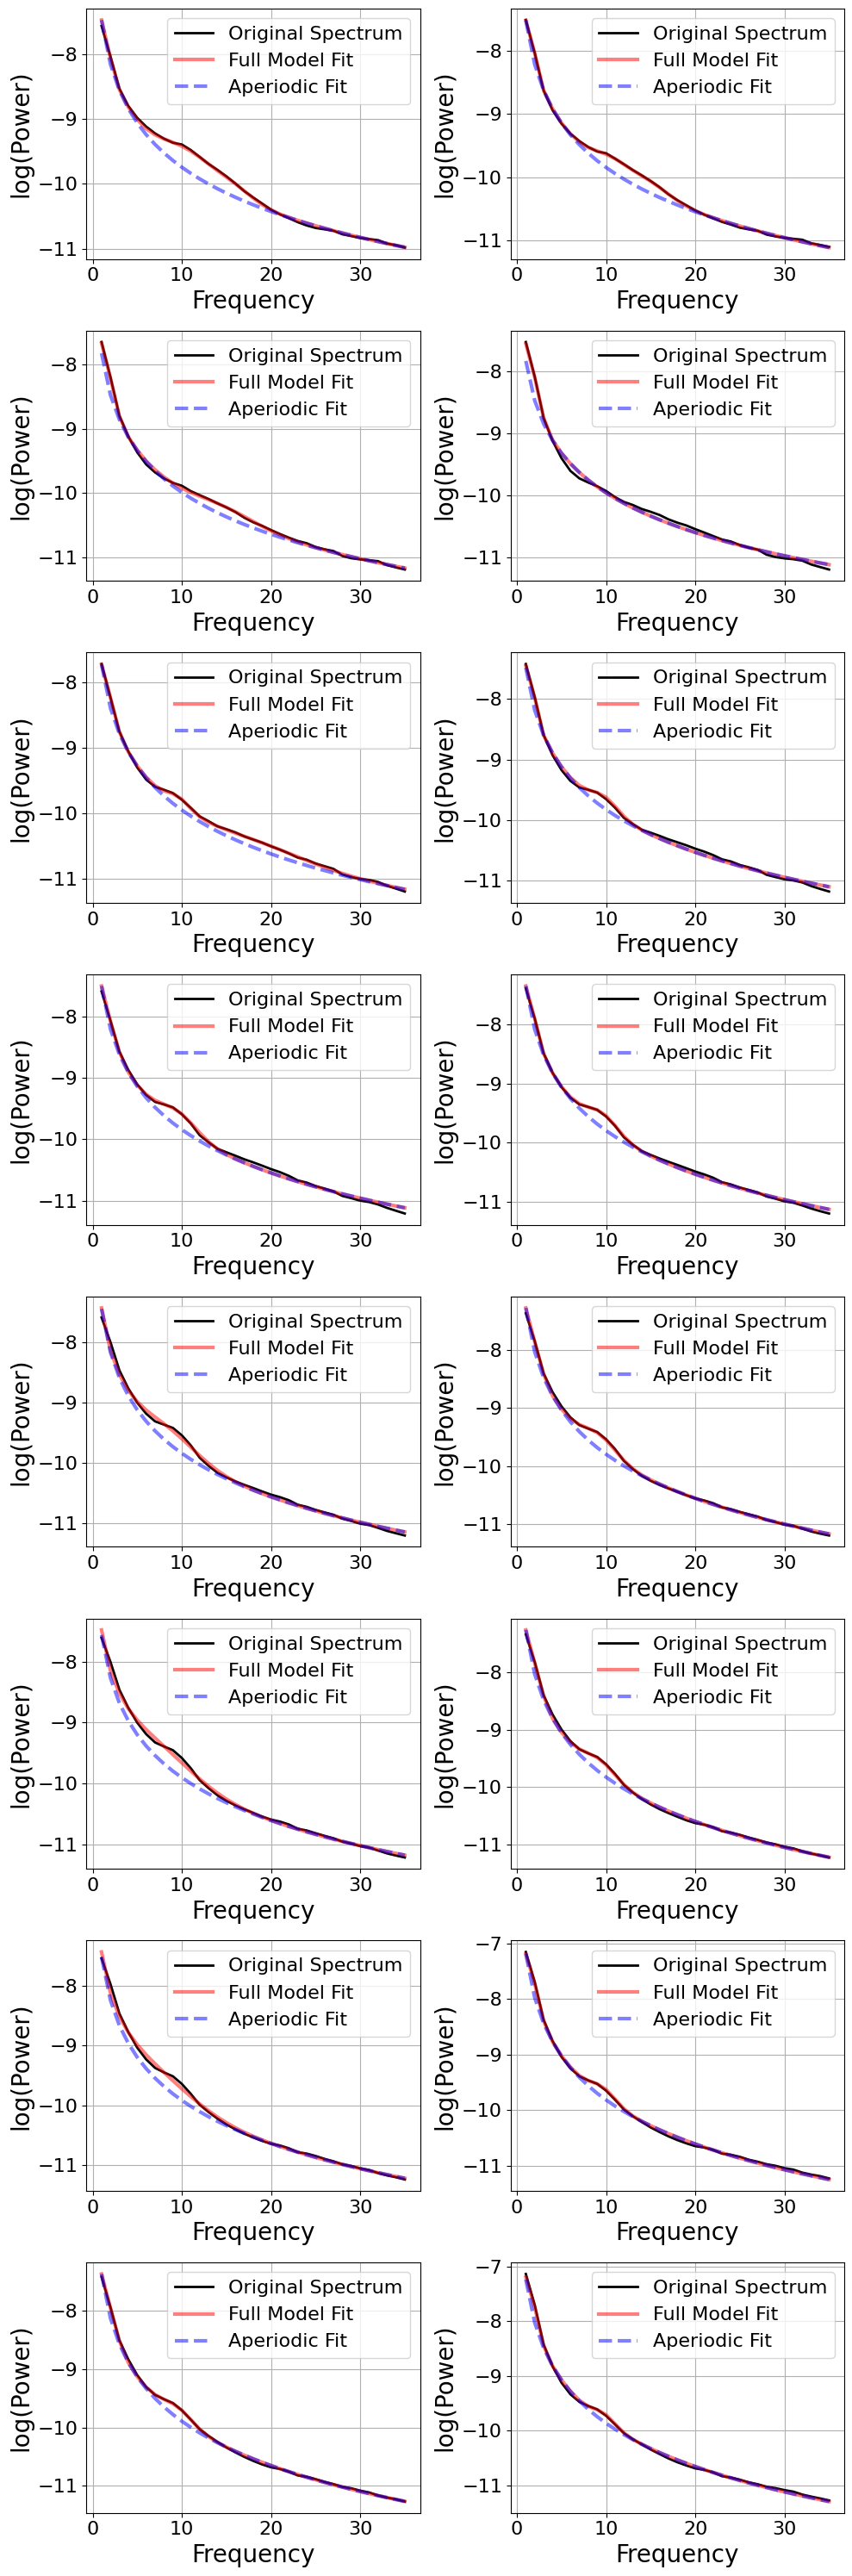

In [17]:
# for each data file, compute the power spectrum density using welch method, fit fooof model and plot the periodic component
freq_range=[1, 35]

# prepare matplotlib axes
fig, axes = plt.subplots(int(len(ts_1st_probe_filtered)/2), 2, figsize=(10, 30))
axes = axes.flatten()
for i, (ts, ax) in enumerate(zip(ts_1st_probe_filtered, axes)):
    # compute the power spectrum density
    freqs, powers = compute_spectrum_welch(ts, fs=1000)
    # fit fooof model
    fm = FOOOF(verbose=False)
    fm.fit(freqs, powers, freq_range=freq_range)
    # plot the periodic component
    plot_fm(fm, plot_peaks=None, plot_aperiodic=True, plt_log=False, add_legend=True, ax=ax)

plt.tight_layout()
plt.show()

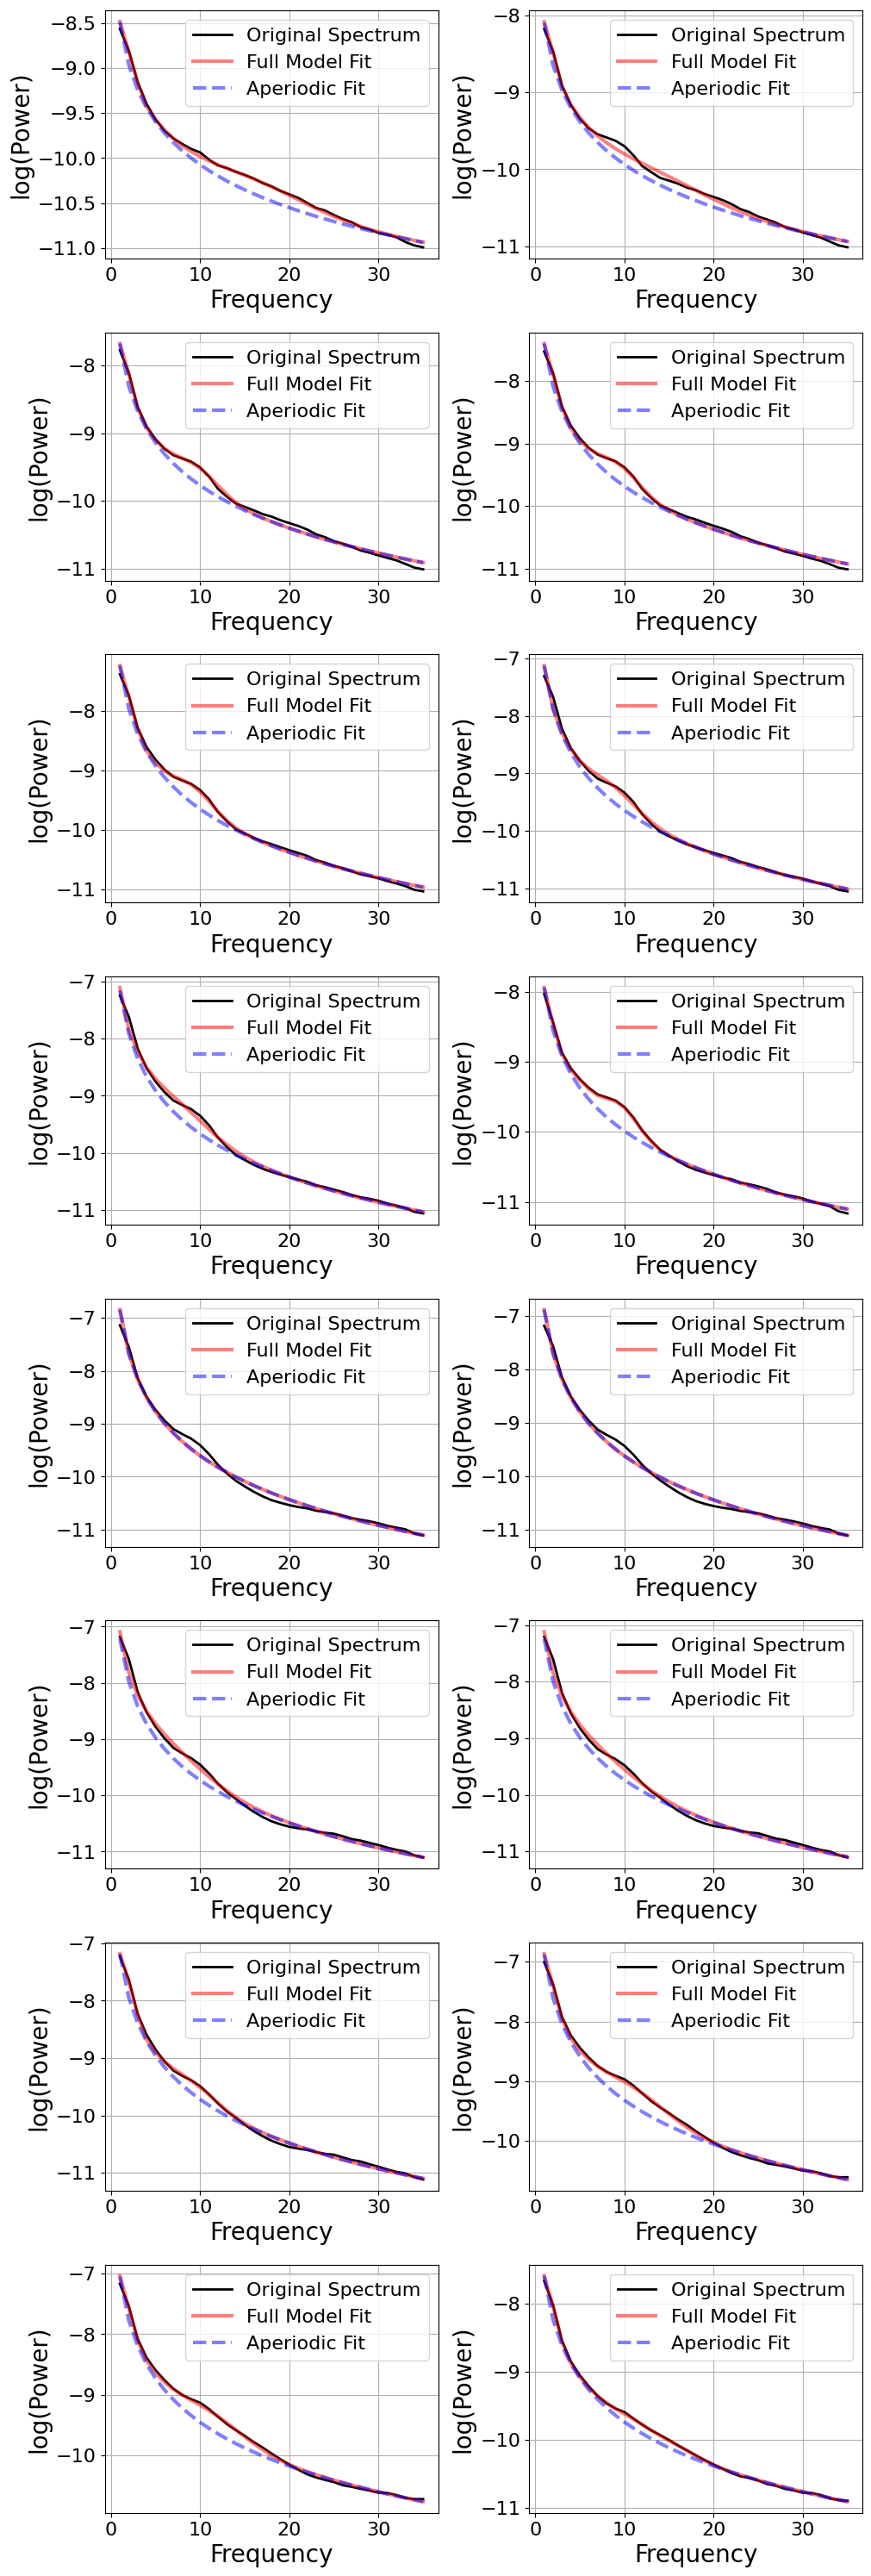

In [18]:
# for each data file, compute the power spectrum density using welch method, fit fooof model and plot the periodic component
freq_range=[1, 35]

# prepare matplotlib axes
fig, axes = plt.subplots(int(len(ts_2nd_probe_filtered)/2), 2, figsize=(10, 30))
axes = axes.flatten()
for i, (ts, ax) in enumerate(zip(ts_2nd_probe_filtered, axes)):
    # compute the power spectrum density
    freqs, powers = compute_spectrum_welch(ts, fs=1000)
    # fit fooof model
    fm = FOOOF(verbose=False)
    fm.fit(freqs, powers, freq_range=freq_range)
    # plot the periodic component
    plot_fm(fm, plot_peaks=None, plot_aperiodic=True, plt_log=False, add_legend=True, ax=ax)

plt.tight_layout()
plt.show()

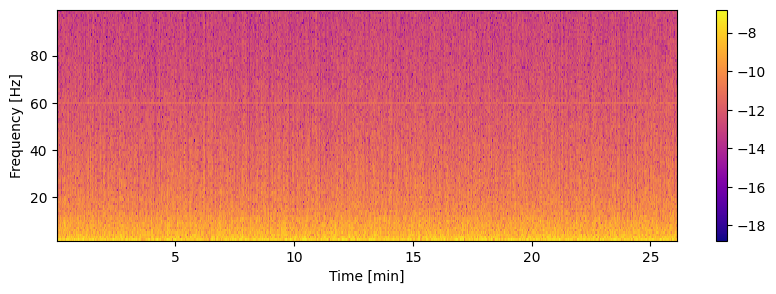

In [28]:
# set figure size
plt.rcParams['figure.figsize'] = [10, 3]
f, t, spec = signal.spectrogram(ts_2nd_probe[4], fs=1000, nperseg=1000, noverlap=900)
ids = np.where((f < 100) & (f > 1))
spec = spec[ids]
freq = f[ids]
# convert time to minutes
t = t/60

# get spec in log scale
spec_log = np.log10(spec)
plt.pcolormesh(t, freq, spec_log, cmap='plasma')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [min]')
# change color scale
plt.colorbar(cmap='plasma')
plt.show()